In [1]:
# load stuff:
import scipy.optimize as so
import datetime as dt

from dataload_helper import Dataset, loadsimpledata
from dataeval_helper import *  # load here also numpy, scipy,...
from global_params import *

import os
from xhistogram.xarray import histogram

In [2]:
S1 = 'JRA-55'
S2 = 'MERRA2'

INT_RES='../Interim_Results/VerticalAnalysis/'

RESLOC='../VerticalAnalysis_Compare/'

names = ['PvsLat_T_','TvsLat_T_','PvsLat_RH_','TvsLat_RH_','PvsLat_DT_','TvsLat_DT_','PvsLat_DRH_','TvsLat_DRH_']

#Times for analysis
t1_start='1980-01-01'
t1_end='1989-12-01'
t2_start='2010-01-01'
t2_end='2019-12-01'


In [3]:
print(f"{INT_RES}{S1}/PvsLat_*0,1*.nc")

ds=xr.open_mfdataset(f"{INT_RES}{S1}/PvsLat_T*0,1*.nc",engine= 'netcdf4')
ds

../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_*0,1*.nc


<xarray.Dataset>
Dimensions:  (lat: 145, p: 37)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 7.0 5.0 3.0 2.0 1.0
Data variables:
    T        (p, lat) float32 dask.array<chunksize=(37, 145), meta=np.ndarray>

In [4]:
xr.open_mfdataset(f"{INT_RES}{S2}/PvsLat_T*0,0*.nc")

<xarray.Dataset>
Dimensions:  (lat: 72, p: 42)
Coordinates:
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.7 0.5 0.4 0.3 0.1
Data variables:
    T        (p, lat) float32 dask.array<chunksize=(42, 72), meta=np.ndarray>

In [5]:
def update_norm(vmin,vmax,vcentner=0):
    global norm
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcentner, vmax=vmax)


def startfig(title):

    cols = ['Mask {}'.format(col) for col in ['Land','Ocean']]
    rows = ['Season {}'.format(row) for row in ['DJF', 'MAM', 'JJA', 'SON']]

    fig, axes = plt.subplots(nrows=4, ncols=2, 
                             figsize=(12, 12),
                             sharex=True, sharey=True,
                             constrained_layout=True,
                            )

    plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')

    fig.suptitle(f'Vertical analysis ({title})',size='x-large',)

    pad = 5 # in points

    for ax, col in zip(axes[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline',
                   )

    for ax, row in zip(axes[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center',
                   )
    
    
    
    
    return fig, axes
    
    
        
def endfig(fig, axes, name:str):
    
    
    cbar=fig.colorbar(artlist, ax=axes, location='right',ticks=np.linspace(vmin, vmax,21))
    #cbar.ax.set_yticklabels(np.linspace(vmin, vmax,10))
    
    # Enable Grid
    [ax.grid(True) for ax in axes.flat]
    #fig.tight_layout()
    #fig.subplots_adjust(left=0.15, top=0.95)
        
    plt.savefig(RESLOC+name,)#dpi=400
    
    plt.show()
    
    return

#xr.open_dataset(file)

In [23]:
DJF=[12,1,2]
MAM=[3,4,5]
JJA=[6,7,8]
SON=[9,10,11]

Ocean=True
Land=False

t1=t1_start
t2=t1_end

def update_params(n):
    global vmin,vmax,levels, cmap
    levels=30
 
    if '_T' in n:    
        vmin=-3
        vmax=3
        cmap=cmap_T
        update_norm(vmin,vmax)
        
    elif '_DT' in n:
        vmin=-1.5
        vmax=1.5
        cmap=cmap_T
        update_norm(vmin,vmax)
    
    elif '_RH' in n:
        vmin=-0.25
        vmax=0.25
        cmap=cmap_RH
        update_norm(vmin,vmax)     
        
    elif '_DRH' in n:
        vmin=-0.1
        vmax=0.1
        cmap=cmap_RH
        update_norm(vmin,vmax)
    
    else:
        raise Exception("Sorry, wrong Name!")


In [24]:
def main():

    
    for n in names:
    
        title=f"{n} - Compare {S2} - {S1}"

        fig, axes = startfig(title)

        update_params(n)

        for i in [0,1,2,3]:
            for j in [0,1]:
                print(f"{INT_RES}{S1}/{n}*{i},{j}*.nc")
                ds1=xr.open_mfdataset(f"{INT_RES}{S1}/{n}*{i},{j}*.nc")
                print(f"{INT_RES}{S2}/{n}*{i},{j}*.nc")
                ds2=xr.open_mfdataset(f"{INT_RES}{S2}/{n}*{i},{j}*.nc")

                global artlist
                
                if 'PvsLat_' in n:
                    #print(ds2)
                    #ds2 = ds2.reindex_like(ds1, method='nearest')
                    #print(ds2)
                    #print(ds1)
                    if "RH" in n:
                        artlist=(ds2-ds1).RH.plot.contourf(ax=axes[i,j],yincrease=False,norm=norm, levels=levels, x='lat',y='p',cmap=cmap,add_colorbar =False,)
                    else:
                        artlist=(ds2-ds1).T.plot.contourf(ax=axes[i,j],yincrease=False,norm=norm, levels=levels, x='lat',y='p',cmap=cmap,add_colorbar =False,)
                
                elif 'TvsLat_' in n:
                    #print(ds1)
                    ds2 = ds2.reindex_like(ds1, method='nearest')
                    #print(ds2)
                    #print(ds2-ds1)
                    if "RH" in n:
                        print(ds1)
                        artlist=(ds2-ds1).histogram_lat_T.plot(ax=axes[i,j],yincrease=False,norm=norm, levels=levels, x='lat_bin',y='T_bin',cmap=cmap,add_colorbar =False,)
                    else:
                        artlist=(ds2-ds1).histogram_lat_T.plot(ax=axes[i,j],yincrease=False,norm=norm, levels=levels, x='lat_bin',y='T_bin',cmap=cmap,add_colorbar =False,)
                
                
                else:
                    raise Exception("Sorry, wrong variable!") 


        endfig(fig,axes,n)

../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_T_*0,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_T_*0,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_T_*0,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_T_*0,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_T_*1,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_T_*1,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_T_*1,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_T_*1,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_T_*2,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_T_*2,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_T_*2,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_T_*2,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_T_*3,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_T_*3,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_T_*3,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_T_*3,1*.nc


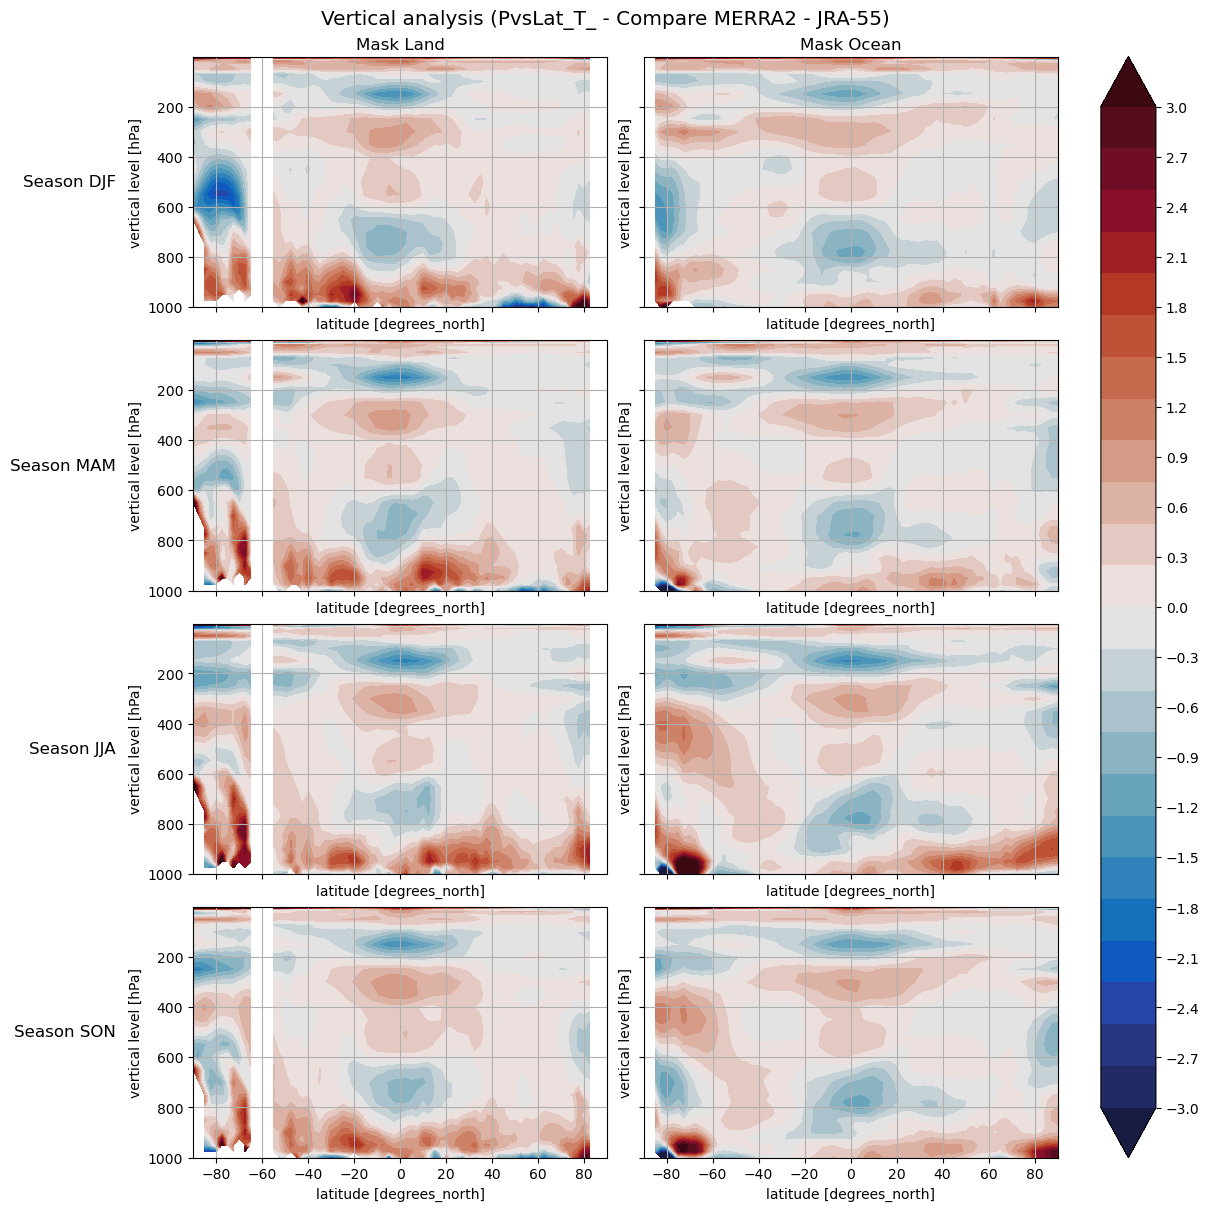

../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_T_*0,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_T_*0,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_T_*0,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_T_*0,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_T_*1,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_T_*1,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_T_*1,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_T_*1,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_T_*2,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_T_*2,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_T_*2,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_T_*2,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_T_*3,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_T_*3,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_T_*3,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_T_*3,1*.nc


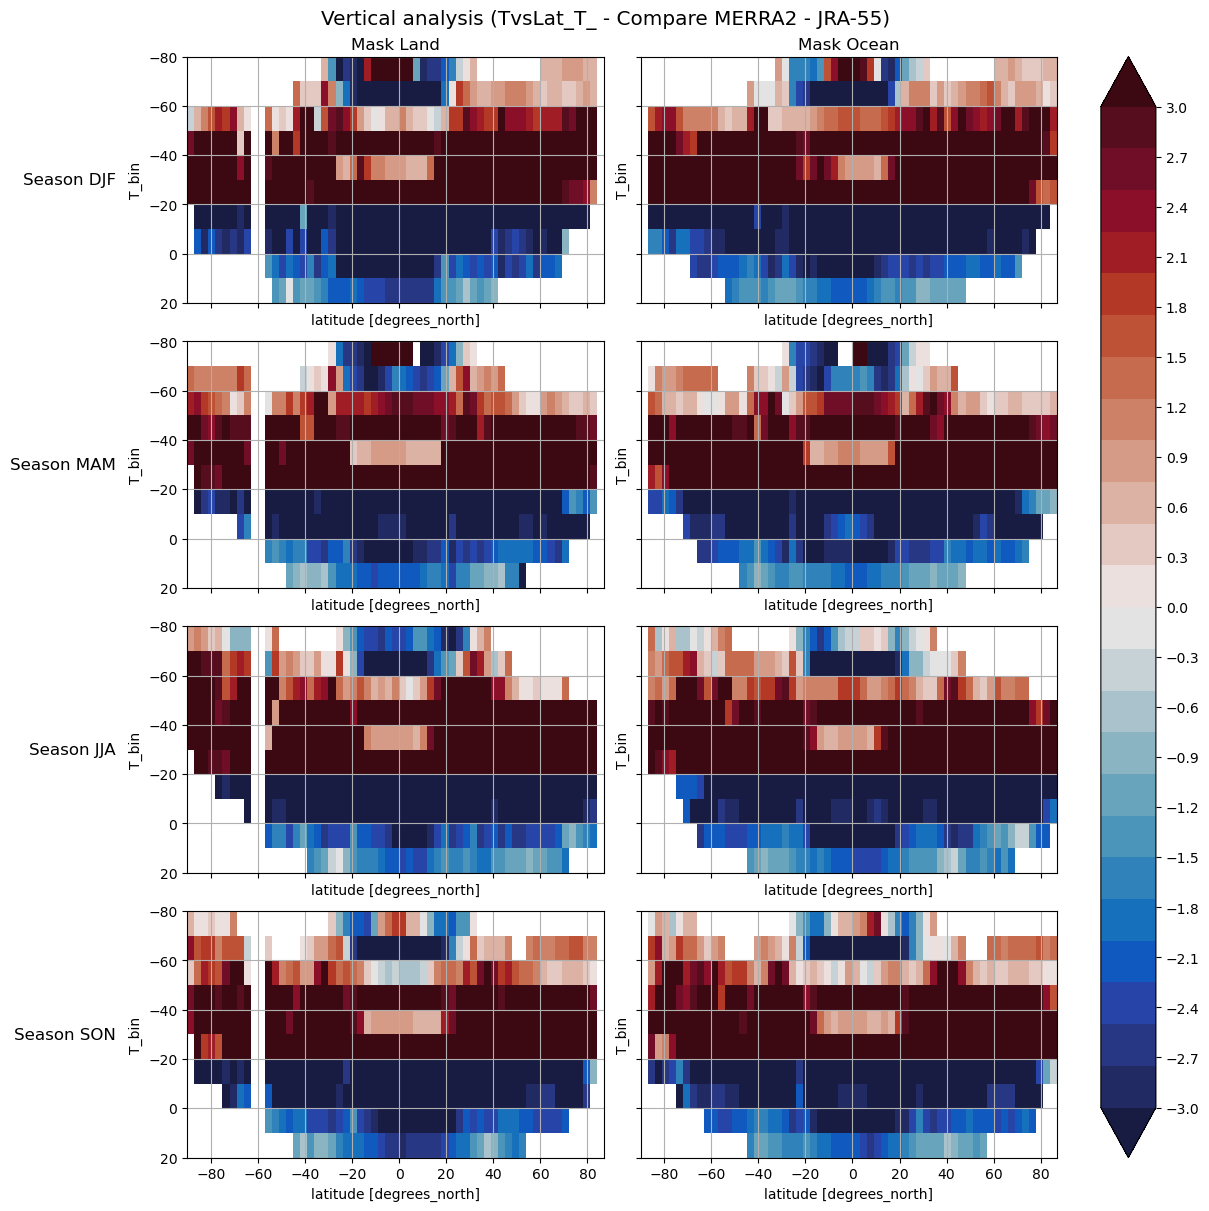

../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_RH_*0,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_RH_*0,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_RH_*0,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_RH_*0,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_RH_*1,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_RH_*1,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_RH_*1,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_RH_*1,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_RH_*2,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_RH_*2,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_RH_*2,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_RH_*2,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_RH_*3,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_RH_*3,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_RH_*3,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_RH_*3,1*.nc


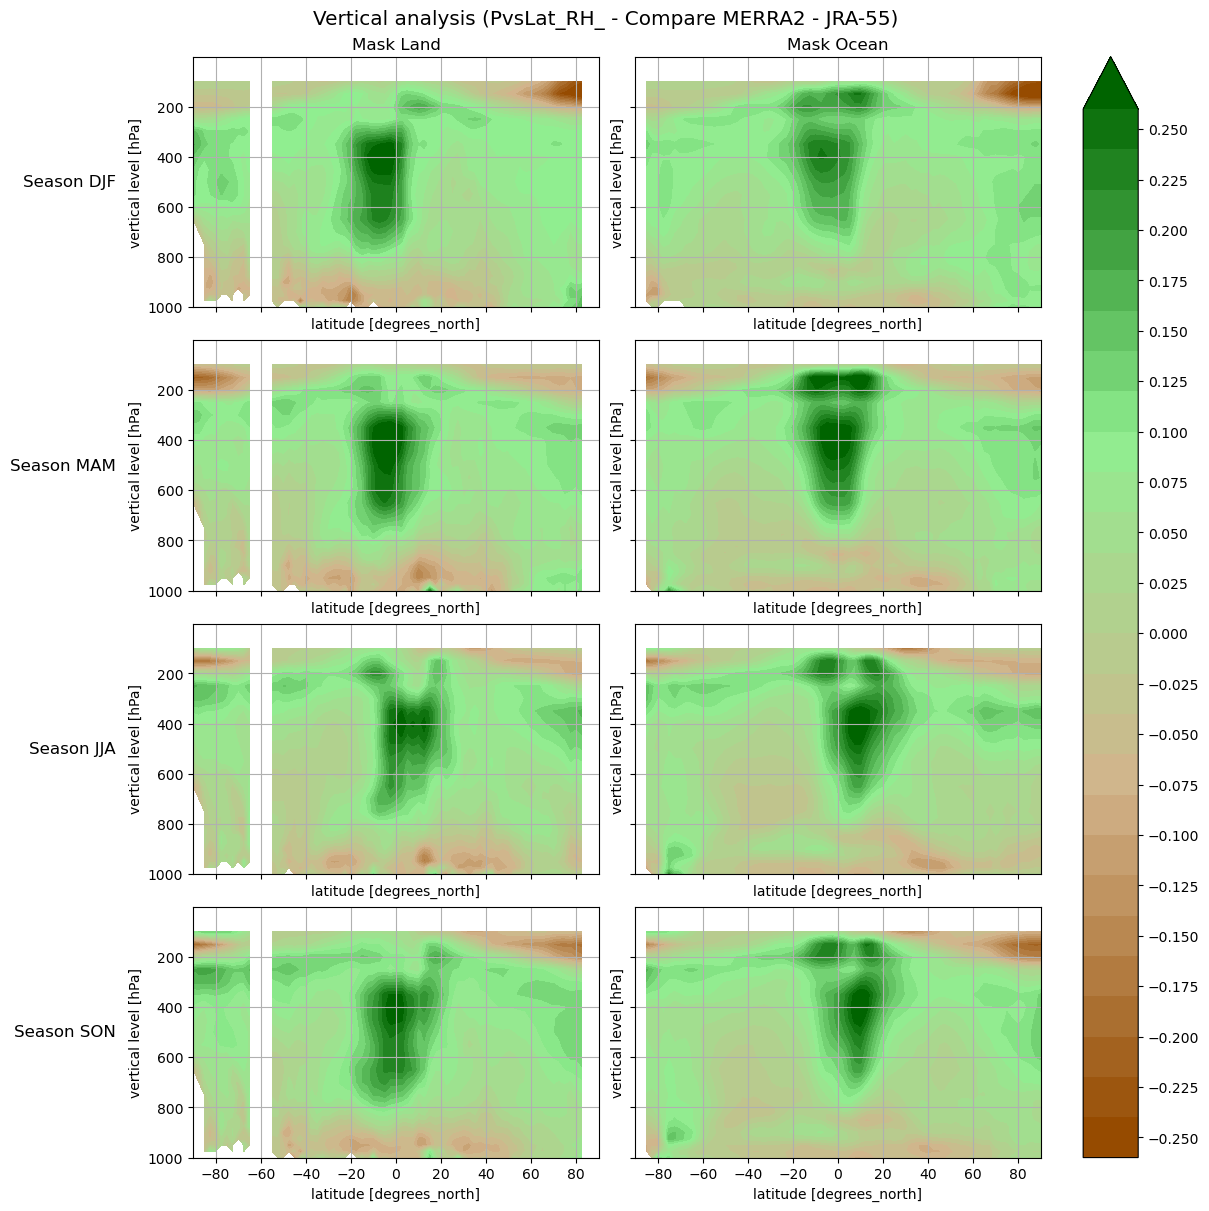

../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_RH_*0,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_RH_*0,0*.nc
<xarray.Dataset>
Dimensions:          (lat_bin: 59, T_bin: 10)
Coordinates:
  * lat_bin          (lat_bin) float64 -88.5 -85.5 -82.5 ... 79.5 82.5 85.5
  * T_bin            (T_bin) float64 -75.0 -65.0 -55.0 -45.0 ... -5.0 5.0 15.0
Data variables:
    histogram_lat_T  (lat_bin, T_bin) float64 dask.array<chunksize=(59, 10), meta=np.ndarray>
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_RH_*0,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_RH_*0,1*.nc
<xarray.Dataset>
Dimensions:          (lat_bin: 59, T_bin: 10)
Coordinates:
  * lat_bin          (lat_bin) float64 -88.5 -85.5 -82.5 ... 79.5 82.5 85.5
  * T_bin            (T_bin) float64 -75.0 -65.0 -55.0 -45.0 ... -5.0 5.0 15.0
Data variables:
    histogram_lat_T  (lat_bin, T_bin) float64 dask.array<chunksize=(59, 10), meta=np.ndarray>
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_RH_*1,0*.nc
../Inter

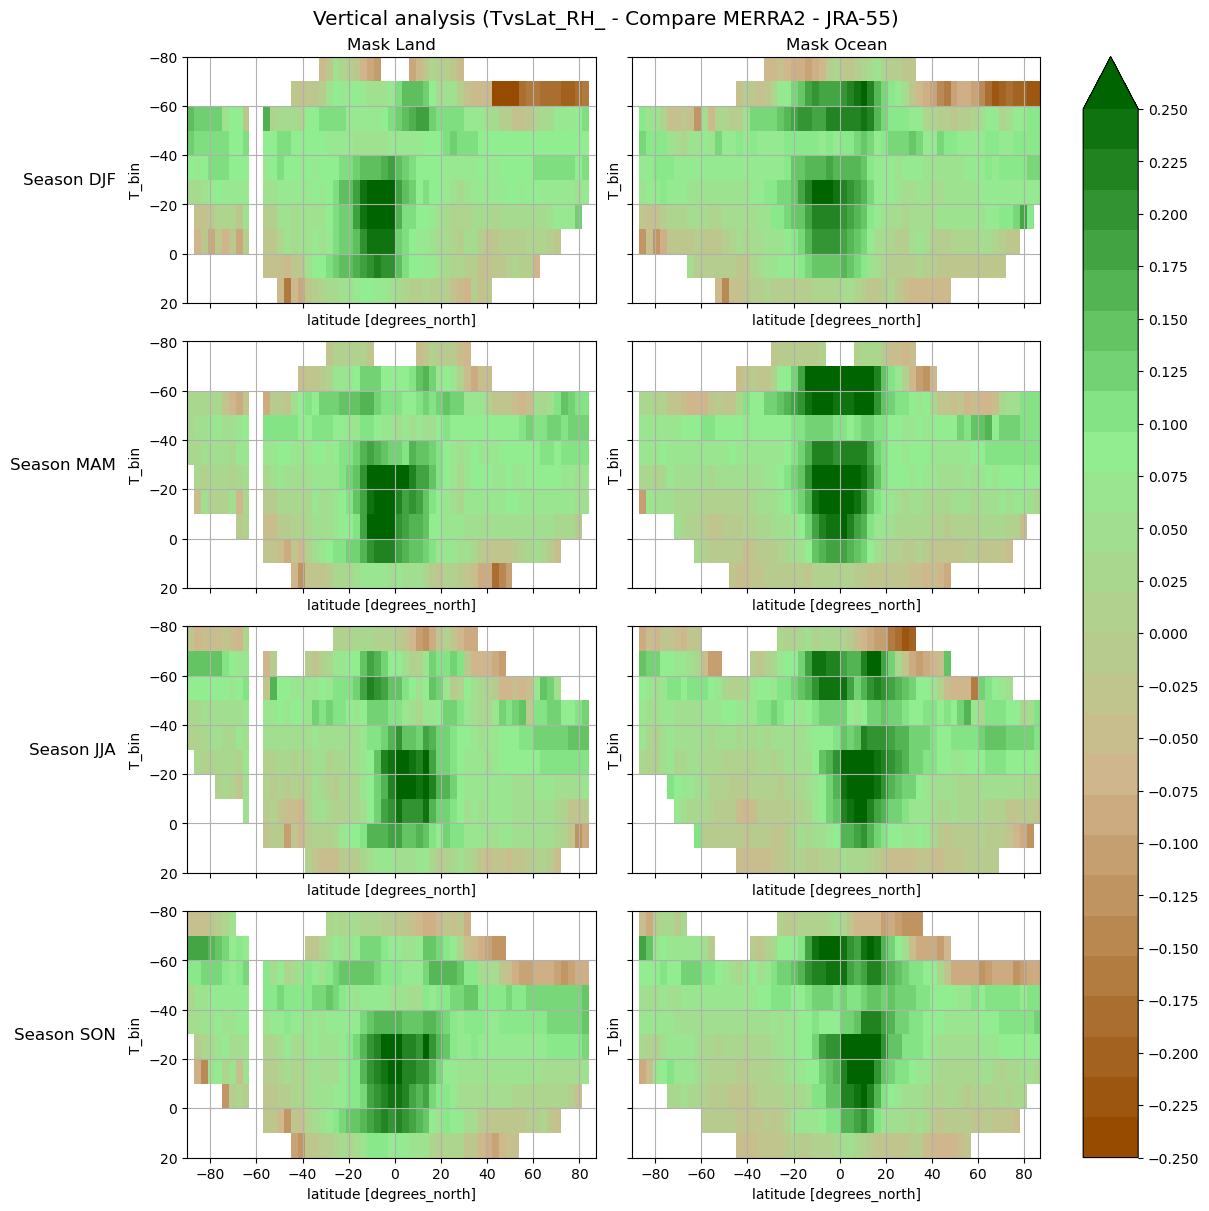

../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DT_*0,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DT_*0,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DT_*0,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DT_*0,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DT_*1,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DT_*1,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DT_*1,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DT_*1,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DT_*2,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DT_*2,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DT_*2,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DT_*2,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DT_*3,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DT_*3,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DT_*3,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DT_*3,1*.nc


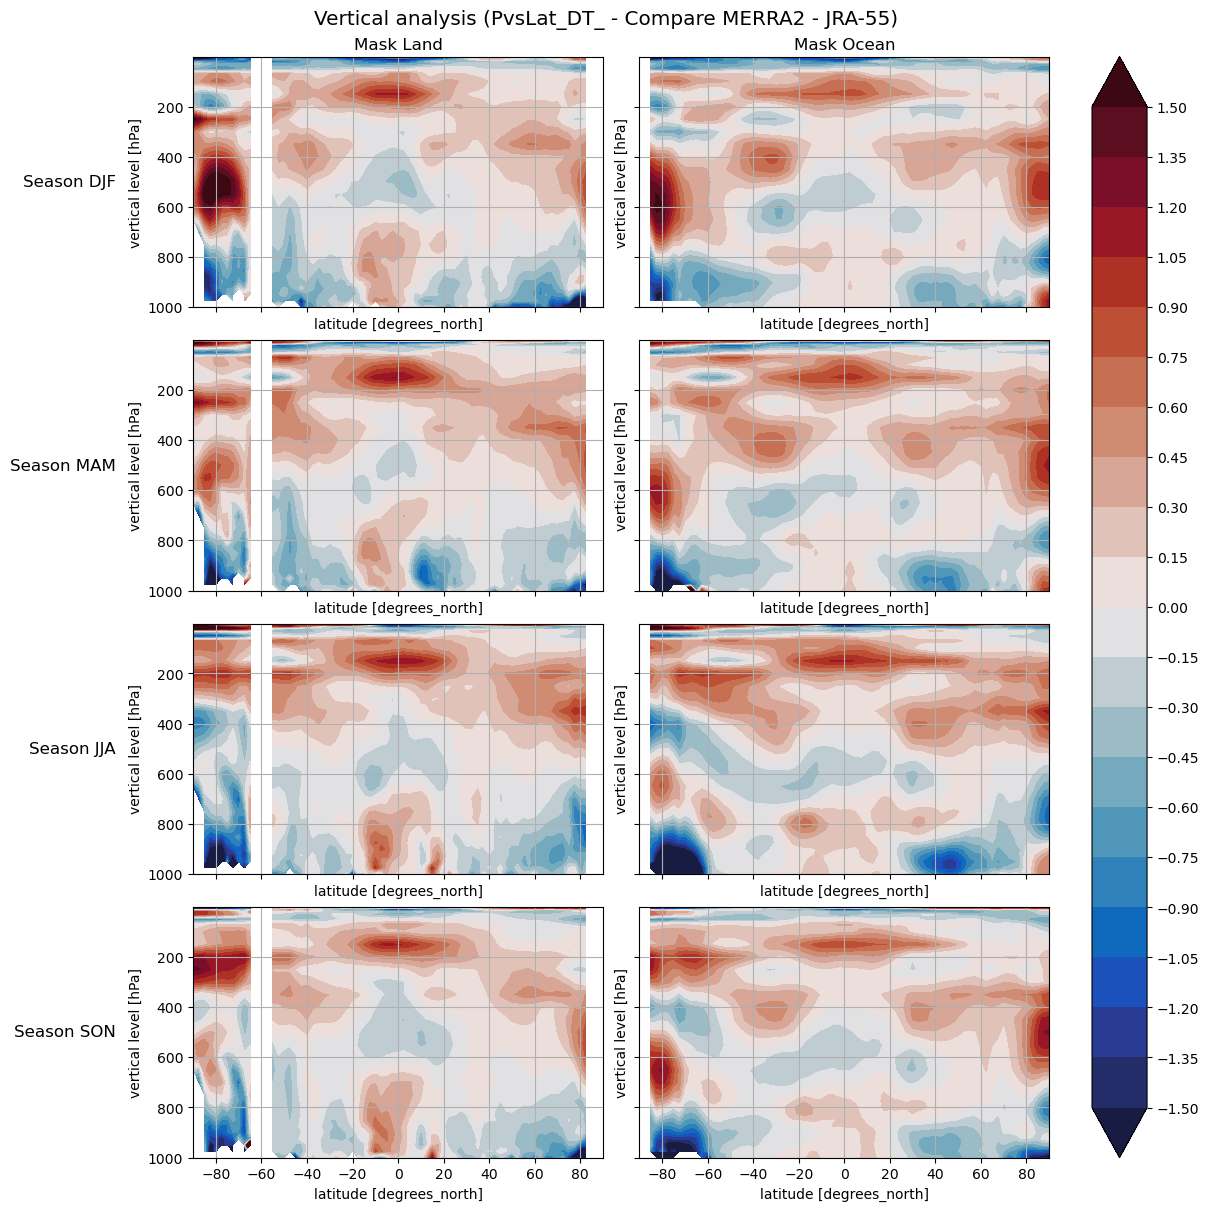

../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DT_*0,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_DT_*0,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DT_*0,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_DT_*0,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DT_*1,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_DT_*1,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DT_*1,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_DT_*1,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DT_*2,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_DT_*2,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DT_*2,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_DT_*2,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DT_*3,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_DT_*3,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DT_*3,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_DT_*3,1*.nc


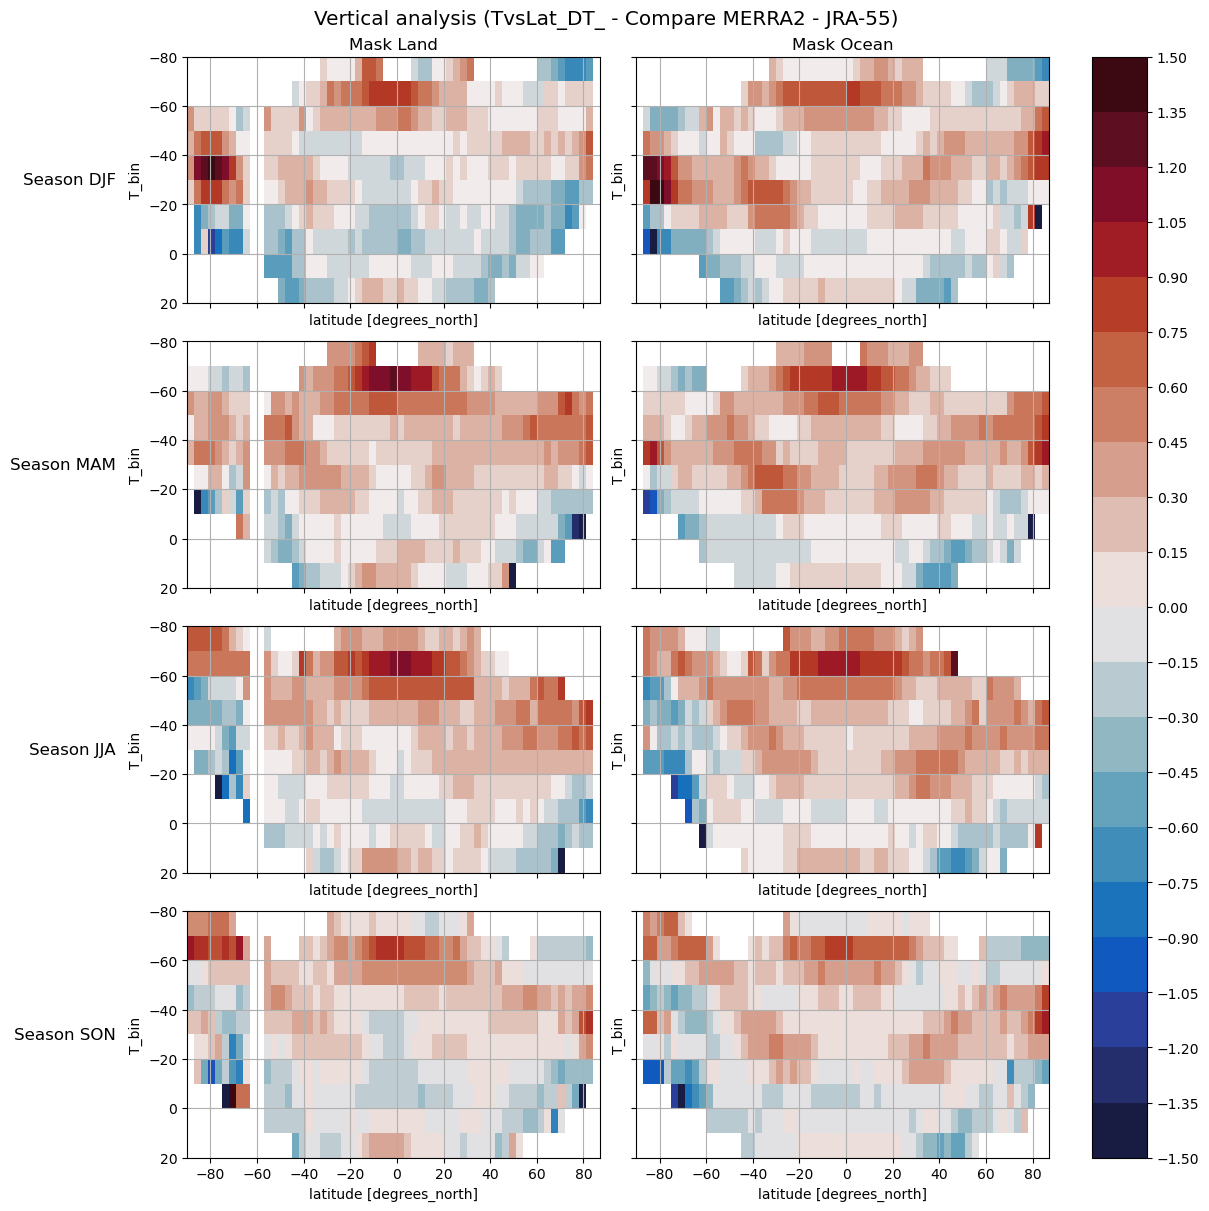

../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DRH_*0,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DRH_*0,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DRH_*0,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DRH_*0,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DRH_*1,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DRH_*1,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DRH_*1,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DRH_*1,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DRH_*2,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DRH_*2,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DRH_*2,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DRH_*2,1*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DRH_*3,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DRH_*3,0*.nc
../Interim_Results/VerticalAnalysis/JRA-55/PvsLat_DRH_*3,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/PvsLat_DRH_*

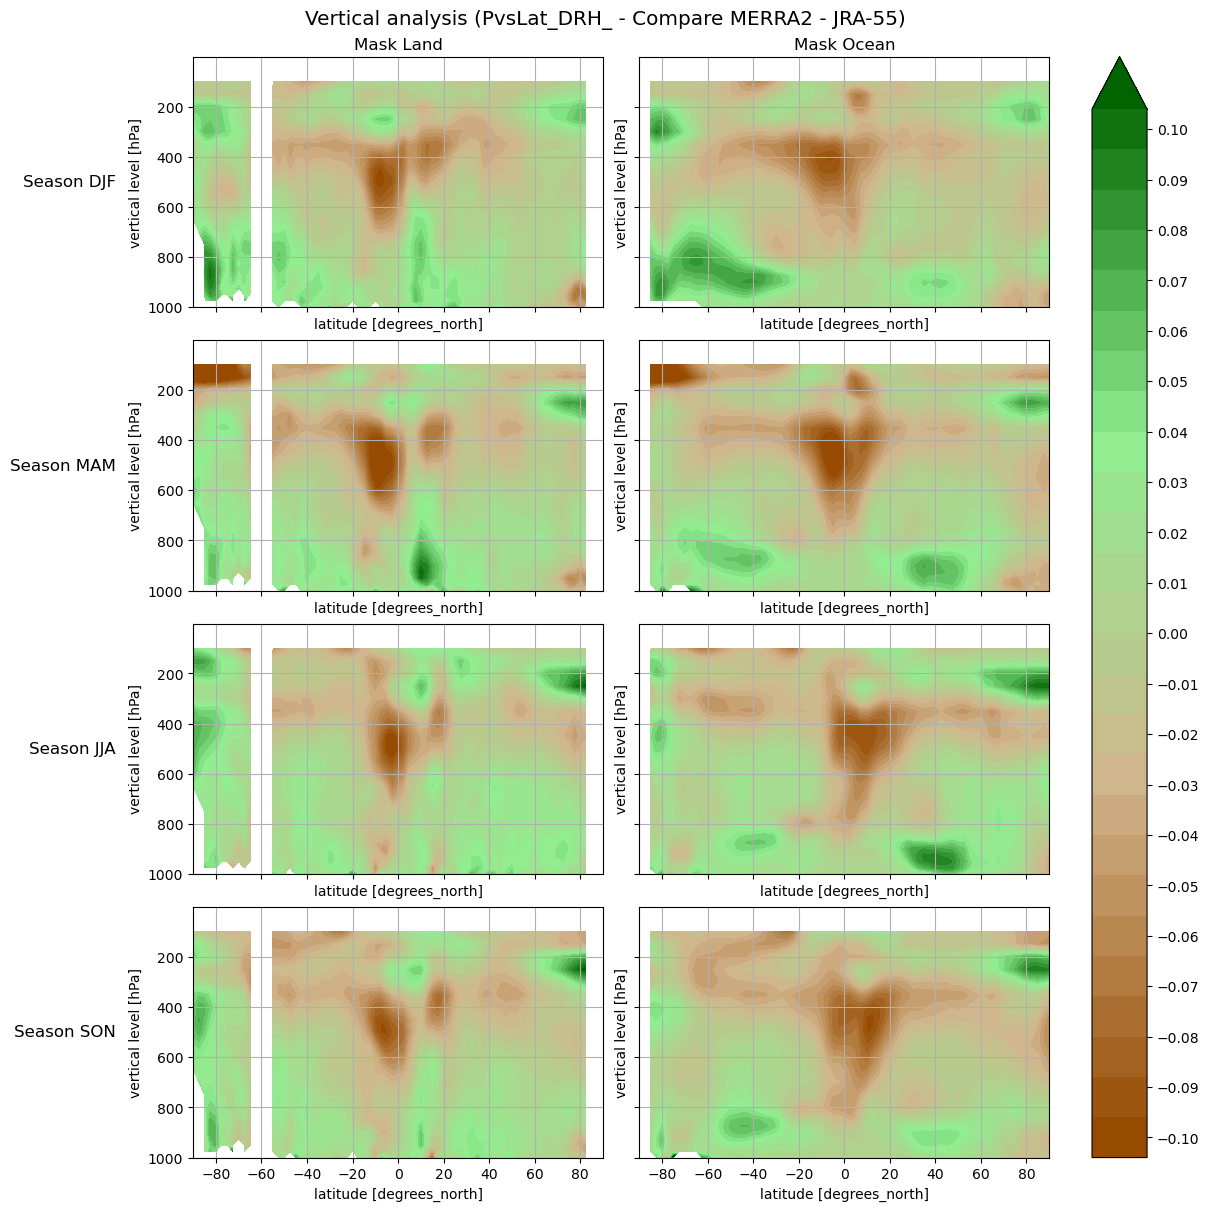

../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DRH_*0,0*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_DRH_*0,0*.nc
<xarray.Dataset>
Dimensions:          (lat_bin: 59, T_bin: 10)
Coordinates:
  * lat_bin          (lat_bin) float64 -88.5 -85.5 -82.5 ... 79.5 82.5 85.5
  * T_bin            (T_bin) float64 -75.0 -65.0 -55.0 -45.0 ... -5.0 5.0 15.0
Data variables:
    histogram_lat_T  (lat_bin, T_bin) float64 dask.array<chunksize=(59, 10), meta=np.ndarray>
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DRH_*0,1*.nc
../Interim_Results/VerticalAnalysis/MERRA2/TvsLat_DRH_*0,1*.nc
<xarray.Dataset>
Dimensions:          (lat_bin: 59, T_bin: 10)
Coordinates:
  * lat_bin          (lat_bin) float64 -88.5 -85.5 -82.5 ... 79.5 82.5 85.5
  * T_bin            (T_bin) float64 -75.0 -65.0 -55.0 -45.0 ... -5.0 5.0 15.0
Data variables:
    histogram_lat_T  (lat_bin, T_bin) float64 dask.array<chunksize=(59, 10), meta=np.ndarray>
../Interim_Results/VerticalAnalysis/JRA-55/TvsLat_DRH_*1,0*.nc
../

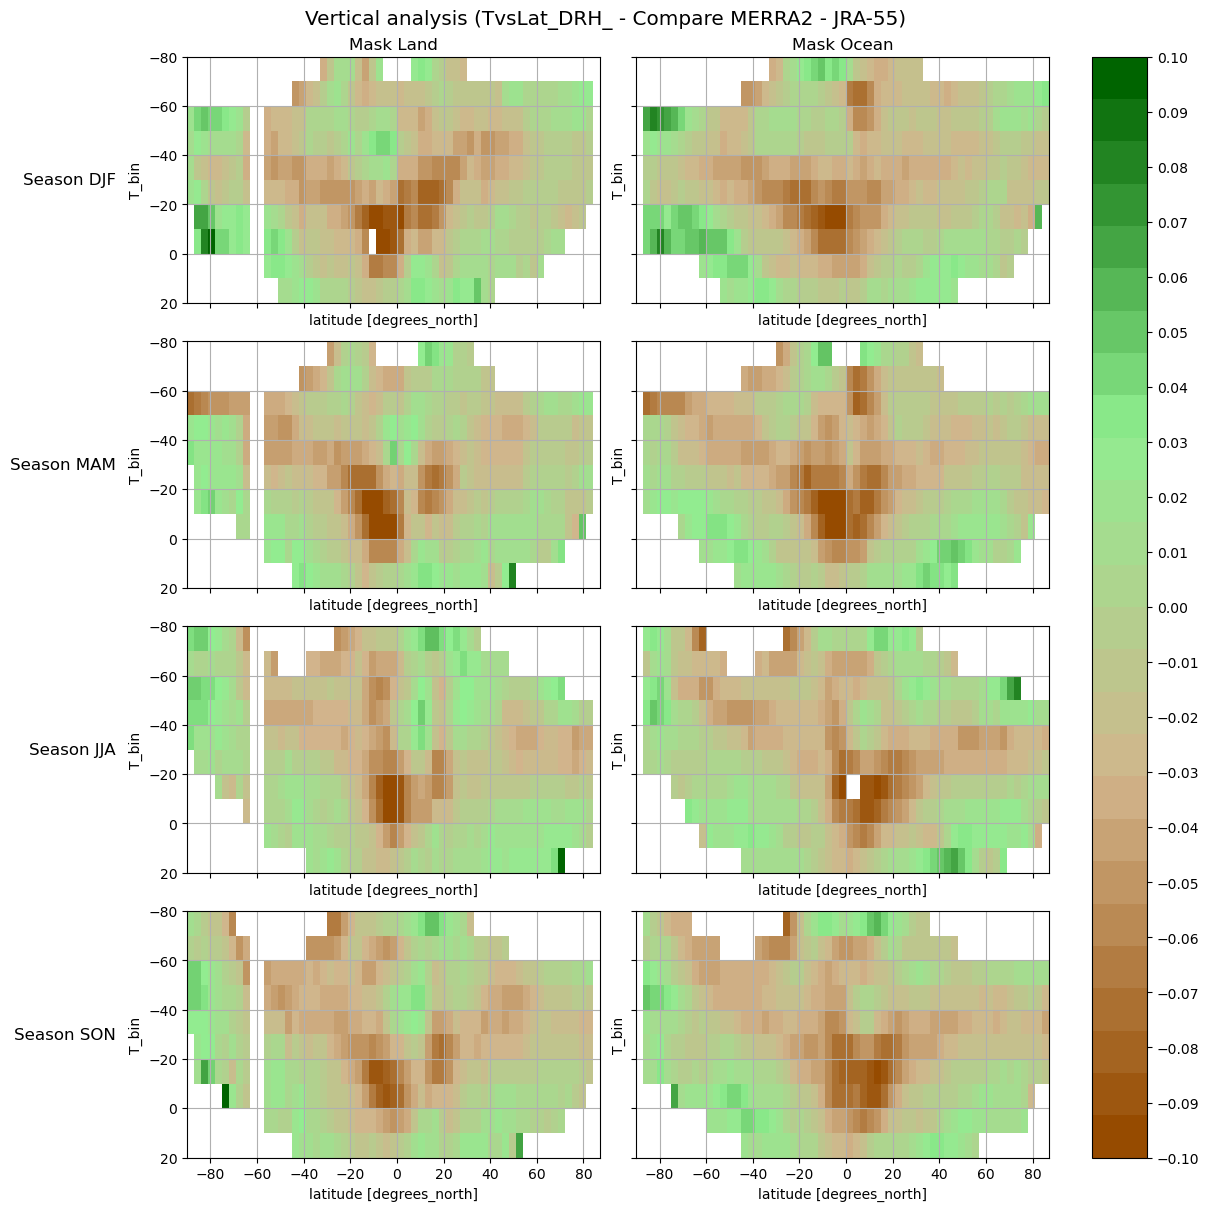

In [25]:
main()